# Lift and Learn (Least Squares) example for Fitzhugh-Nagumo Equation

## Fitzhugh-Nagumo Equation 

The Fitzhugh-Nagumo equation is a simplified mathematical model used to describe the behavior of excitable systems, particularly the dynamics of nerve cells or neurons. It was developed independently by Richard Fitzhugh and John Nagumo in the 1960s as a modification of the Hodgkin-Huxley model, aiming to capture the essential characteristics of action potential propagation.

The equation takes the form of a system of ordinary differential equations and consists of two main variables: a fast-recovery variable (usually denoted as v) and a slow-activating variable (usually denoted as w). The Fitzhugh-Nagumo equation is given by:
$$
\begin{align*}
    \frac{dv}{dt} &= v - \frac{v^3}{3} - w + I \\
    \frac{dw}{dt} &= \epsilon (v + a - bw)
\end{align*}
$$
where:
- v represents the membrane potential of the neuron.
- w represents a recovery variable related to the inactivation of ion channels.
- I is an external input current that stimulates the neuron.
- ε is a positive parameter that controls the timescale separation between v and w dynamics.
- a and b are constants that affect the equilibrium points and behavior of the system.

The Fitzhugh-Nagumo model simplifies the complex behavior of neurons, focusing on the interplay between the fast-responding action potential and the slower recovery process. This simplification makes it easier to analyze and understand the fundamental mechanisms underlying excitable systems. The Fitzhugh-Nagumo equation has been widely used in the study of neuronal dynamics, cardiac rhythm modeling, and other excitable phenomena, providing insights into the generation and propagation of electrical signals in various biological and physical contexts.

## Setup

In [1]:
using BlockDiagonals
using Kronecker
using LinearAlgebra
using NaNStatistics
using Plots
using ProgressMeter
using Random
using Statistics
using LiftAndLearn
const LnL = LiftAndLearn
;

## Generate the Models

In [2]:
start = time()
Ω = (0.0, 1.0); dt = 1e-4; Nx = 2^9
fhn = LnL.FitzHughNagumoModel(
    spatial_domain=Ω, time_domain=(0.0,4.0), Δx=(Ω[2] - 1/Nx)/Nx, Δt=dt,
    alpha_input_params=[500, 50000], beta_input_params=[10, 15]
)

# Some options for operator inference
options = LnL.LSOpInfOption(
    system=LnL.SystemStructure(
        is_lin=true,
        is_quad=true,
        is_bilin=true,
        has_control=true,
        has_output=true,
        has_const=true,
        has_funcOp=true,
        is_lifted=true,
    ),
    vars=LnL.VariableStructure(
        N=2,
        N_lift=3,
    ),
    data=LnL.DataStructure(
        Δt=dt,
        DS=100,
    ),
    optim=LnL.OptimizationSetting(
        verbose=true,
        which_quad_term="H",
        reproject=true,
    ),
)

# grid points
gp = fhn.spatial_dim

# Downsampling
DS = options.data.DS

##########################################################
## Get the full-order model operators for intrusive model
##########################################################
tmp = fhn.lifted_finite_diff_model(gp, fhn.spatial_domain[2])
fomLinOps = LnL.Operators(
    A=tmp[1],
    B=tmp[2][:, :],  # Make sure its matrix
    C=tmp[3][:, :],
    H=tmp[4],
    F=LnL.H2F(tmp[4]),
    N=tmp[5],
    K=tmp[6]
)

@info "(t=$(time()-start)) Complete generating intrusive model operators"

# Generic function for FOM
tmp = fhn.full_order_model(gp, fhn.spatial_domain[2])  # much efficient to calculate for FOM
fomOps = LnL.Operators(
    A=tmp[1],
    B=tmp[2][:, :],  # Make sure its a matrix
    C=tmp[3][:, :],
    K=tmp[4],
    f=tmp[5]
)
fom_state(x, u) = fomOps.A * x + fomOps.B * u + fomOps.f(x) + fomOps.K

@info "(t=$(time()-start)) Complete generating full-order model operators"

┌ Info: (t=3.889000177383423) Complete generating intrusive model operators
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\03_fhn_LnL_LS.ipynb:55
┌ Info: (t=4.006999969482422) Complete generating full-order model operators
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\03_fhn_LnL_LS.ipynb:68


## Generate training data

In [3]:
# parameters for the training data
α_train = vec([500 5000 50000] .* ones(3))
β_train = vec([10 12.5 15]' .* ones(3)')

###################### (I) Create training data ###########################
Xtrain = Vector{Matrix{Float64}}(undef, length(α_train))
Utrain = Vector{Matrix{Float64}}(undef, length(α_train))
Utrain_all = Vector{Matrix{Float64}}(undef, length(α_train))

@showprogress for i in axes(α_train, 1)
    α, β = α_train[i], β_train[i]
    genU(t) = α * t^3 * exp(-β * t)  # generic function for input

    ## training data for inferred dynamical models
    X = LnL.forwardEuler(fom_state, genU, fhn.tspan, fhn.IC)
    Xtrain[i] = X[:, 1:DS:end]  # make sure to only record every 0.01s
    U = genU.(fhn.tspan)
    Utrain_all[i] = U'
    Utrain[i] = U[1:DS:end]'
end
Xtr = reduce(hcat, Xtrain)
Utr = reshape(reduce(hcat, Utrain), :, 1)  # make sure that the U matrix is a tall matrix (x-row & t-col)
Ytr = fomOps.C * Xtr

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


2×3609 Matrix{Float64}:
 0.0  0.0323271    0.0635394   …  0.00253059  0.00625911  0.0100019
 0.0  0.000575308  0.00129599     0.0441213   0.0437643   0.0434329

## Check that the training data looks fine

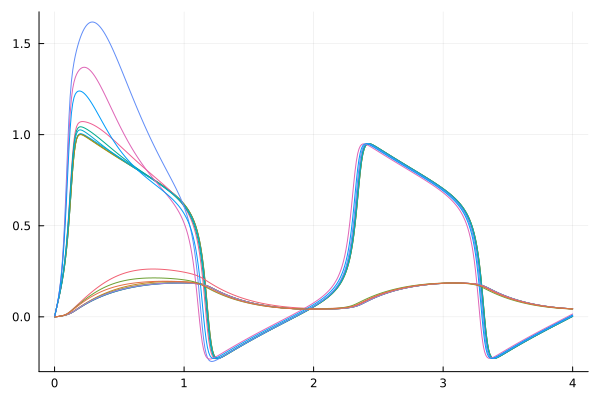

In [4]:
p = plot(fhn.tspan[1:DS:end], Xtrain[1][1, :], legend=false, show=true)
plot!(p, fhn.tspan[1:DS:end], Xtrain[1][gp+1, :], legend=false)
for i in 2:8
    plot!(p, fhn.tspan[1:DS:end], Xtrain[i][1, :], legend=false)
    plot!(p, fhn.tspan[1:DS:end], Xtrain[i][gp+1, :], legend=false)
end
plot!(p, fhn.tspan[1:DS:end], Xtrain[9][1, :], legend=false)
plot!(p, fhn.tspan[1:DS:end], Xtrain[9][gp+1, :], legend=false)
display(p)

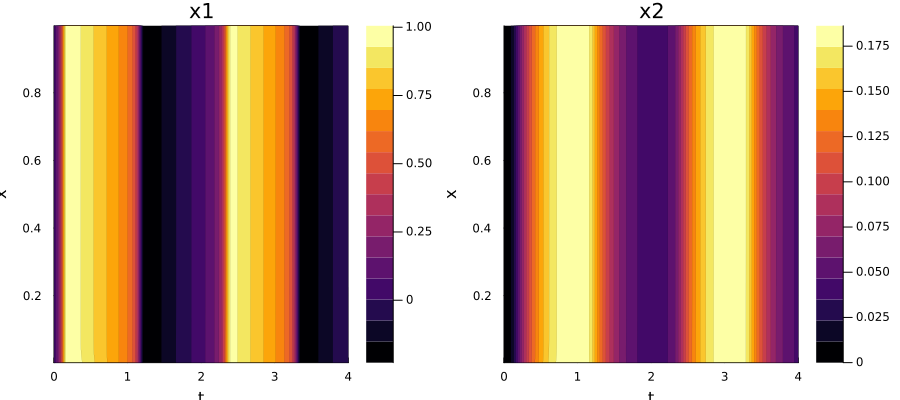

In [5]:
# Contour plot
p1 = contourf(fhn.tspan[1:DS:end],fhn.xspan,Xtrain[1][1:gp, :],lw=0, xlabel="t", ylabel="x", title="x1")
p2 = contourf(fhn.tspan[1:DS:end],fhn.xspan,Xtrain[1][gp+1:end, :],lw=0, xlabel="t", ylabel="x", title="x2")

l = @layout [a b]
p = plot(p1, p2, layout=l, size=(900, 400), show=true)
display(p)


## Generate test data

In [6]:
################### (II) Create testing data 1 ############################
N_tests = 16

# Parameters for the testing data (1)
α_test1 = vec(rand(N_tests, 1) .* (fhn.alpha_input_params[2] - fhn.alpha_input_params[1]) .+ fhn.alpha_input_params[1])
β_test1 = vec(rand(N_tests, 1) .* (fhn.beta_input_params[2] - fhn.beta_input_params[1]) .+ fhn.beta_input_params[1])

Xtest1 = Vector{Matrix{Float64}}(undef, N_tests)
Utest1 = Vector{Matrix{Float64}}(undef, N_tests)
Utest1_all = Vector{Matrix{Float64}}(undef, N_tests)
@showprogress for i in axes(α_test1, 1)
    α, β = α_test1[i], β_test1[i]
    genU(t) = α * t^3 * exp(-β * t)  # generic function for input

    @inbounds X = LnL.forwardEuler(fom_state, genU, fhn.tspan, fhn.IC)
    Xtest1[i] = X[:, 1:DS:end]  # make sure to only record every 0.01s
    U = genU.(fhn.tspan)
    Utest1_all[i] = U'
    Utest1[i] = U[1:DS:end]'
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


In [7]:
################### (III) Create testing data 2 ###########################
N_test_sqrt = Int(sqrt(N_tests))
# Parameters for testing data (2)
α_test2 = vec((5 * 10 .^ range(start=4, stop=6, length=N_test_sqrt))' .* ones(N_test_sqrt))
β_test2 = vec(range(start=15, stop=20, length=N_test_sqrt) .* ones(N_test_sqrt)')

Xtest2 = Vector{Matrix{Float64}}(undef, N_tests)
Utest2 = Vector{Matrix{Float64}}(undef, N_tests)
Utest2_all = Vector{Matrix{Float64}}(undef, N_tests)
@showprogress for i in axes(α_test2, 1)
    α, β = α_test2[i], β_test2[i]
    genU(t) = α * t^3 * exp(-β * t)  # generic function for input

    @inbounds X = LnL.forwardEuler(fom_state, genU, fhn.tspan, fhn.IC)
    Xtest2[i] = X[:, 1:DS:end]  # make sure to only record every 0.01s
    U = genU.(fhn.tspan)
    Utest2_all[i] = U'
    Utest2[i] = U[1:DS:end]'
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


## Learn and Test

In [11]:
##################### (IV~VII) Learn & Analysis ###########################
mode_req = [1 1 1; 2 1 3; 3 3 4; 5 4 5]  # Required number of modes for each lifted variables

# Data lifting
Xsep = [Xtr[1:gp, :], Xtr[gp+1:end, :]]
lifter = LnL.lifting(options.vars.N, options.vars.N_lift, [x -> x[1] .^ 2])
Wtr = lifter.map(Xsep)


# Take the SVD for each variable
W1 = svd(Wtr[1:gp, :])
W2 = svd(Wtr[gp+1:2*gp, :])
W3 = svd(Wtr[2*gp+1:end, :])

# dictionary with intrusive and LnL errors as matrices (9-by-4)
train_err = Dict(
    :intrusive => zeros(length(α_train), size(mode_req, 1)),
    :inferred => zeros(length(α_train), size(mode_req, 1))
)
test1_err = Dict(
    :intrusive => zeros(N_tests, size(mode_req, 1)),
    :inferred => zeros(N_tests, size(mode_req, 1))
)
test2_err = Dict(
    :intrusive => zeros(N_tests, size(mode_req, 1)),
    :inferred => zeros(N_tests, size(mode_req, 1))
)

@showprogress for (i, row) in enumerate(eachrow(mode_req))
    r1, r2, r3 = row
    Vr1 = W1.U[:, 1:r1]
    Vr2 = W2.U[:, 1:r2]
    Vr3 = W3.U[:, 1:r3]
    Vr = BlockDiagonal([Vr1, Vr2, Vr3])

    infOps = LnL.opinf(Wtr,Vr, lifter, fomOps, options; U=Utr, Y=Ytr)
    intruOps = LnL.pod(fomLinOps, Vr, options)
    # At = Vr' * fomLinOps.A * Vr
    # Bt = Vr' * fomLinOps.B
    # Kt = Vr' * fomLinOps.K
    # Ht = Vr' * fomLinOps.H * (Vr ⊗ Vr)
    # Nt = Vr' * fomLinOps.N * Vr

    # fint(x, u) = fF(intruOps.A, intruOps.B, intruOps.F, intruOps.N, intruOps.K, x, u)
    finf = (x, u) -> infOps.A * x + infOps.B * u + infOps.H * (x ⊗ x) + (infOps.N * x) * u + infOps.K

    # fint(x, u) = fF(intruOps.A, intruOps.B, intruOps.F, intruOps.N, intruOps.K, x, u)
    fint = (x, u) -> intruOps.A * x  + intruOps.B * u + intruOps.H * (x ⊗ x) + (intruOps.N*x)*u + intruOps.K
    # fint = (x, u) -> At * x + Bt * u + Ht * (x ⊗ x) + (Nt * x) * u + Kt

    k, l = 0, 0
    for (X, U) in zip(Xtrain, Utrain_all)
        Xint = LnL.forwardEuler(fint, U, fhn.tspan, Vr' * fhn.IC_lift)
        Xinf = LnL.forwardEuler(finf, U, fhn.tspan, Vr' * fhn.IC_lift)

        # Down sample 
        Xint = Xint[:, 1:DS:end]
        Xinf = Xinf[:, 1:DS:end]

        train_err[:intrusive][k+=1, i] = LnL.compStateError(X, Xint, Vr)
        train_err[:inferred][l+=1, i] = LnL.compStateError(X, Xinf, Vr)
    end

    k, l = 0, 0
    for (X, U) in zip(Xtest1, Utest1_all)
        Xint = LnL.forwardEuler(fint, U, fhn.tspan, Vr' * fhn.IC_lift)
        Xinf = LnL.forwardEuler(finf, U, fhn.tspan, Vr' * fhn.IC_lift)

        # Down sample
        Xint = Xint[:, 1:DS:end]
        Xinf = Xinf[:, 1:DS:end]

        test1_err[:intrusive][k+=1, i] = LnL.compStateError(X, Xint, Vr)
        test1_err[:inferred][l+=1, i] = LnL.compStateError(X, Xinf, Vr)
    end

    k, l = 0, 0
    for (X, U) in zip(Xtest2, Utest2_all)
        Xint = LnL.forwardEuler(fint, U, fhn.tspan, Vr' * fhn.IC_lift)
        Xinf = LnL.forwardEuler(finf, U, fhn.tspan, Vr' * fhn.IC_lift)

        # Down sample
        Xint = Xint[:, 1:DS:end]
        Xinf = Xinf[:, 1:DS:end]

        test2_err[:intrusive][k+=1, i] = LnL.compStateError(X, Xint, Vr)
        test2_err[:inferred][l+=1, i] = LnL.compStateError(X, Xinf, Vr)
    end
end
dims = sum(mode_req, dims=2)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


4×1 Matrix{Int64}:
  3
  6
 10
 14

## Plot results

In [12]:
err_intru = vec(median(train_err[:intrusive], dims=1))
err_infer = vec(median(train_err[:inferred], dims=1))

t1err_intru = vec(median(test1_err[:intrusive], dims=1))
t1err_infer = vec(median(test1_err[:inferred], dims=1))

t2err_intru = vec(nanmedian(test2_err[:intrusive], dims=1))
t2err_infer = vec(nanmedian(test2_err[:inferred], dims=1));

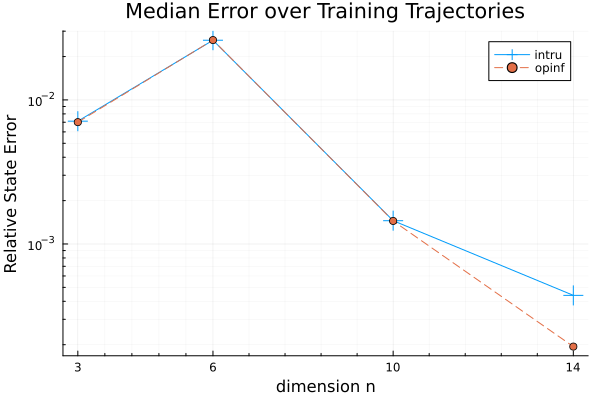

In [13]:
plot(dims, err_intru, marker=(:cross, 10), label="intru")
plot!(dims, err_infer, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)
tmp = log10.(err_infer)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(vec(dims))
xlabel!("dimension n")
ylabel!("Relative State Error")
title!("Median Error over Training Trajectories")

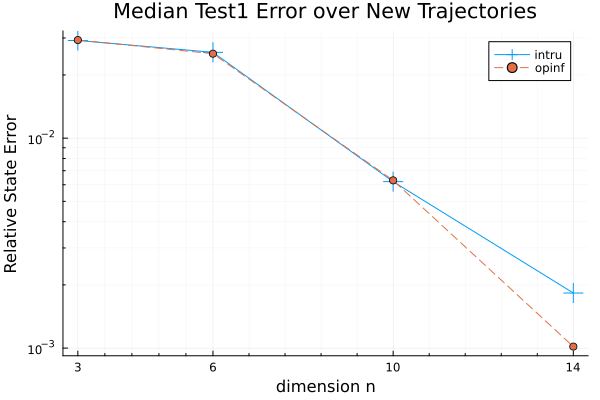

In [14]:
plot(dims, t1err_intru, marker=(:cross, 10), label="intru")
plot!(dims, t1err_infer, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)
tmp = log10.(t1err_infer)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(vec(dims))
xlabel!("dimension n")
ylabel!("Relative State Error")
title!("Median Test1 Error over New Trajectories")

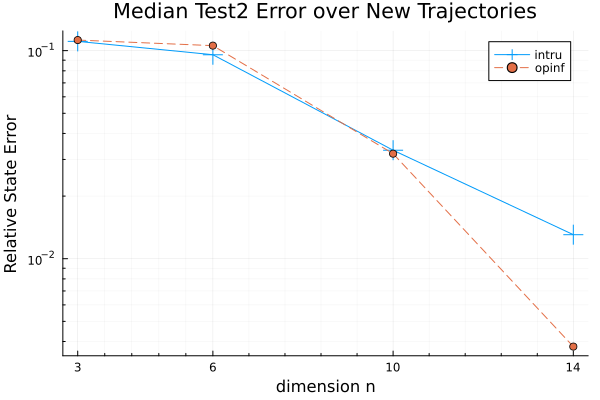

In [15]:
plot(dims, t2err_intru, marker=(:cross, 10), label="intru")
plot!(dims, t2err_infer, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)
tmp = log10.(t2err_infer)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(vec(dims))
xlabel!("dimension n")
ylabel!("Relative State Error")
title!("Median Test2 Error over New Trajectories")